# 5.1 Interface behavior represented by damage

&nbsp;<font color="brown">
**Basic concept of damage models? When to use them? What are their advantages and limitations?**
</font>

**Outline**
* Define and visualize examples of damage functions in 1D
* How to use an isotropic damage model to represent the material behavior of a 2D interface? 

In [1]:
%matplotlib notebook
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

**Damage versus plasticity in view of algorithmic treatment**

Recall that for models based on plasticity, return mapping was necessary to return back to an admissible state. 

In case of damage models, the relation between strain and stress is an explicit function. 

This means that <font color="blue"> no return-mapping</font> is necessary. Given the strain increment, the corresponding stress can be directly evaluated.

**Damage versus multi-linear models in view of algorithmic treatment**

Recall that the multi-linear models of the bond behavior also allowed for an explicit evaluation without return-mapping:

&nbsp;<font color="brown">
**So why to use damage representation for bond behavior? What is the added value compared to multi-linear elastic models?**
</font>

 1. <font color="blue">To distinguish unloading/reloading in the most simple way</font>
     * Damage model remembers a measure of maximum strain $\kappa$ attained during history.
 2. <font color="blue">Two dimensional bond behavior</font>
     * Damage state can be shared or can interact across dimensions 


In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [3]:
# This code is needed to lambdify expressions named with latex symbols
# it removes the backslashes and curly braces upon before code generation.
from sympy.utilities.codegen import codegen
import re
def _print_Symbol(self, expr):
    CodePrinter = sp.printing.codeprinter.CodePrinter
    name = super(CodePrinter, self)._print_Symbol(expr)
    return re.sub(r'[\\\{\}]', '', name)
sp.printing.codeprinter.CodePrinter._print_Symbol = _print_Symbol

# Stress - slip relations
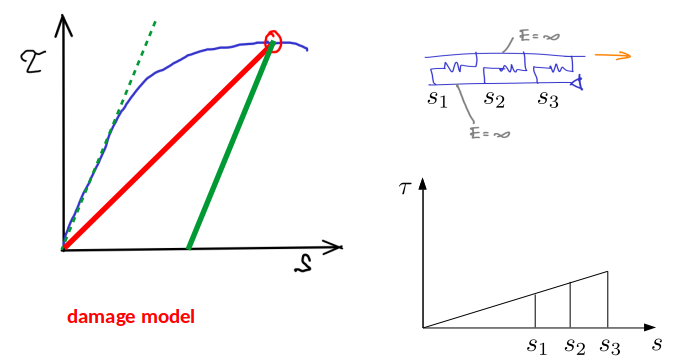
\begin{align}
\tau &= \psi E_\mathrm{b} s = (1 - \omega) E_\mathrm{b} s
\end{align}

In [4]:
psi, E_b, s = sp.symbols(r'\psi, E_b, s')
tau_psi_ = psi * E_b * s
tau_psi_

# How to construct a damage evolution function 

A natural choice of a function representing the decay of stiffness is an exponential function with negative exponent.
\begin{align}
g(s) = \exp(-s)
\end{align}
 In any finite-element code such a function can be found. They differ in the way the parameters of the function can be controlled.

<IPython.core.display.Javascript object>


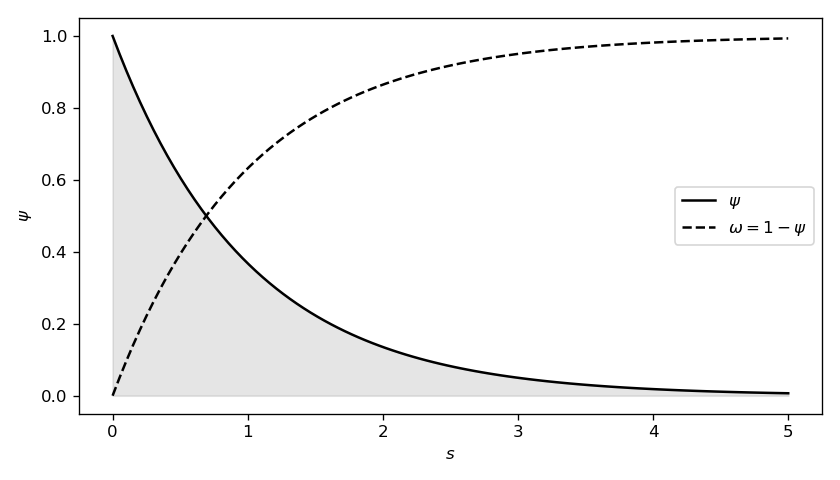

In [5]:
g_kappa_ =  sp.exp(-s)
get_kappa = sp.lambdify(s, g_kappa_)
s_arr = np.linspace(0.0,5,100)
_, ax = plt.subplots(1,1,figsize=(7,4),tight_layout=True)
ax.plot(s_arr, get_kappa(s_arr), color='black', label=r'$\psi$')
ax.plot(s_arr, 1-get_kappa(s_arr), linestyle='dashed', color='black', label=r'$\omega = 1 - \psi$')
ax.fill_between(s_arr, get_kappa(s_arr), color='gray', alpha=0.2)
ax.set_ylabel(r'$\psi$'); ax.set_xlabel(r'$s$')
ax.legend();

# Common state of and material parameters exponential damage functions

**Common state variables and material parameters:**

Symbol | Variable |
:-------:|:--------------------|
 $s$    | slip
 $\tilde{s}$ | measure of equivalent slip
 $\psi$ | integrity
 $\omega$ | damage = 1 - integrity ($\omega = 1 - \psi$)
 $\kappa$ | maximum slip attained till the current control time $t$
 $E_\mathrm{b}$ | initial stiffness
 $s_0$ | slip at onset of damage |
 
 > In 1D interface $\tilde{s} = s$, in 2D interface, e.g. $\tilde{s} = \sqrt{s_x^2 + s_y^2}$

In [6]:
s_equiv, s_0, omega = sp.symbols(r'\tilde{s}, s_0, \omega')

We need some plotting infrastructure to compare different models ...

In [7]:
def plot_damage(s_arr, g_arr, tau_arr):
    # plot the damage and stress evolution in a single diagram
    f, (ax_tau) = plt.subplots(1,1,figsize=(10,5), tight_layout=True)
    ax_omega = ax_tau.twinx()
    ax_omega.plot(s_arr, 1-g_arr, color='red', label=r'$\omega$')
    ax_tau.plot(s_arr, tau_arr, color='black', label=r'$\tau$');
    ax_omega.set_ylabel(r'$\omega$')
    ax_tau.set_xlabel(r'$\tilde{s}$'); ax_tau.set_ylabel(r'$\tau$');
    ax_tau.fill_between(s_arr, tau_arr, color='gray', alpha=0.2)
    ax_omega.fill_between(s_arr, 1-g_arr, color='red', alpha=0.1)
    f.legend()
    return ax_tau

## Loss-of-integrity controlled by the slope $s_\mathrm{f}$  
\begin{align}
g(\tilde{s}) = \left[\frac{s_0}{\tilde{s}} \exp \left(- \frac{\tilde{s} - s_0}{s_\mathrm{f} - s_0}\right)\right]
\end{align}

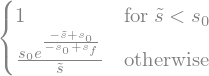

In [8]:
s_f = sp.symbols(r's_f')
g1_s_equiv_ =  (s_0 / s_equiv * sp.exp(-(s_equiv-s_0)/(s_f-s_0) ) )
g1_ = sp.Piecewise( (1, s_equiv < s_0), (g1_s_equiv_, True) )
g1_

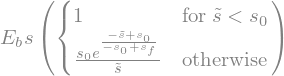

In [9]:
tau1_ = tau_psi_.subs(psi, g1_)
tau1_

<IPython.core.display.Javascript object>


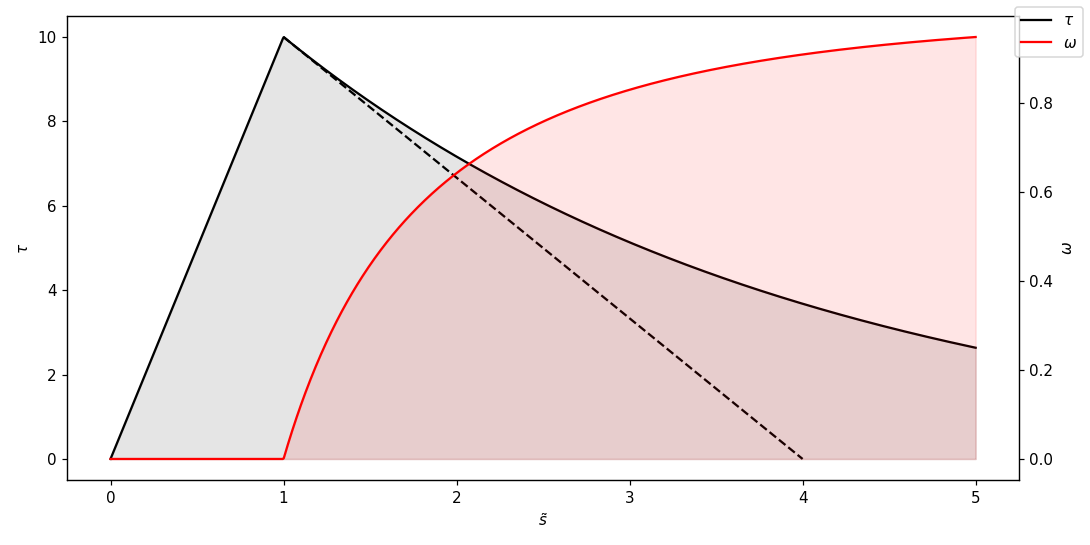

In [23]:
get_g1 = sp.lambdify((s_equiv, s_0, s_f, '**kw'), g1_, 'numpy',)
get_tau1 = sp.lambdify((s, s_equiv, E_b, s_0, s_f, '**kw'), tau1_, 'numpy')
s_arr = np.linspace(0.0001,5,1000)
ax = plot_damage(s_arr,
                get_g1(s_arr, s_0=1, s_f=4), 
                get_tau1(s_arr, s_arr, E_b=10, s_0=1, s_f=4));
ax.plot([1,4],[10,0],linestyle='dashed', color="black");

## Damage function used in Abaqus
\begin{align}
g(\tilde{s}) = \frac{s_0}{\tilde{s}}\left[ 1 - \frac{1 - \exp \displaystyle\left(- \alpha
\frac{\tilde{s} - s_0}{s_u - s_0}\right)}{1 - \exp(-\alpha)}  \right]
\end{align}


In [24]:
a, s_u = sp.symbols('a, s_u')
g2_s_ =  (s_0 / s_equiv * (1 - (1 - sp.exp(-a*((s_equiv - s_0)/(s_u - s_0)))) / (1 - sp.exp(-a))))
g2_ = sp.Piecewise( (1, s_equiv < s_0), (g2_s_, s_equiv < s_u), (0,True) )
tau2_ = tau_psi_.subs(psi, g2_)

<IPython.core.display.Javascript object>


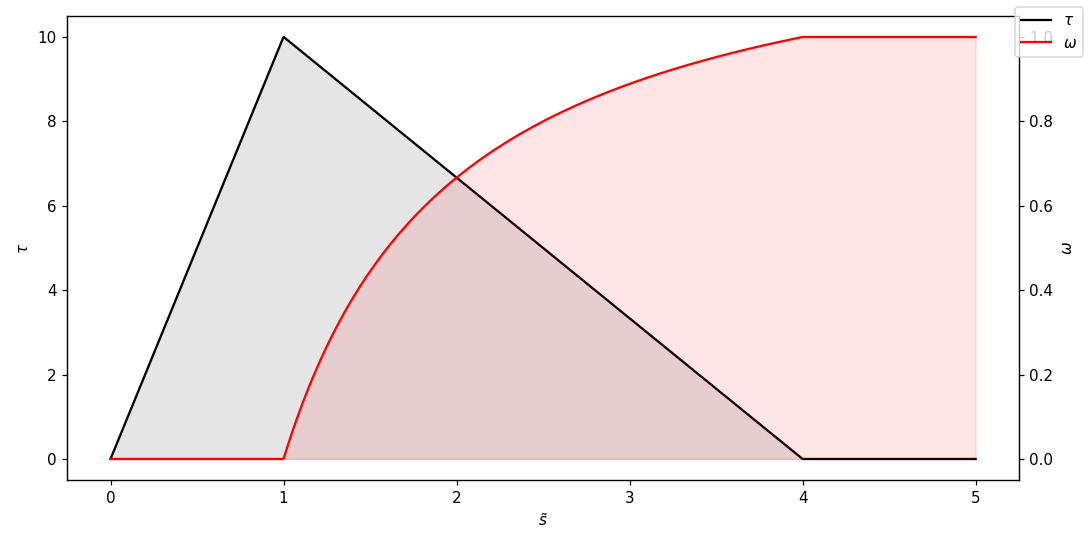

In [27]:
get_g2 = sp.lambdify((s_equiv, s_0, a, s_u, '**kw'), g2_, 'numpy')
get_tau2 = sp.lambdify((s, s_equiv, E_b, s_0, a, s_u, '**kw'), tau2_, 'numpy')
plot_damage(s_arr,
            get_g2(s_arr, s_0=1, a=0.001, s_u=4), 
            get_tau2(s_arr, s_arr, E_b=10, s_0=1, a=0.001, s_u=4));

## Damage function accounting for fracture energy and size
\begin{align}
g(\tilde{s}) = \displaystyle{\frac{s_0}{\tilde{s}}}
\exp\left(\frac{2 E_\mathrm{b} s_0 ( \tilde{s} - s_0) }
{E_\mathrm{b} s^2_0 - 2 G_\mathrm{f}} 
 \right)
\end{align}

| Symbol | Variable |
|:-:|:-|
| $G_\mathrm{f}$ | Fracture energy - represents the area below the $\tau{s}$ curve | 

In [28]:
G_f_0, G_f, L_s = sp.symbols('G_f_0, G_f, L_s')
g3_s_= s_0 / s_equiv * sp.exp((2*E_b*s_0*(s_equiv - s_0))/(E_b*s_0**2 - 2*G_f) )
g3_ = sp.Piecewise( (1, s_equiv < s_0), (g3_s_, True) )
tau3_ = tau_psi_.subs(psi, g3_) 

<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


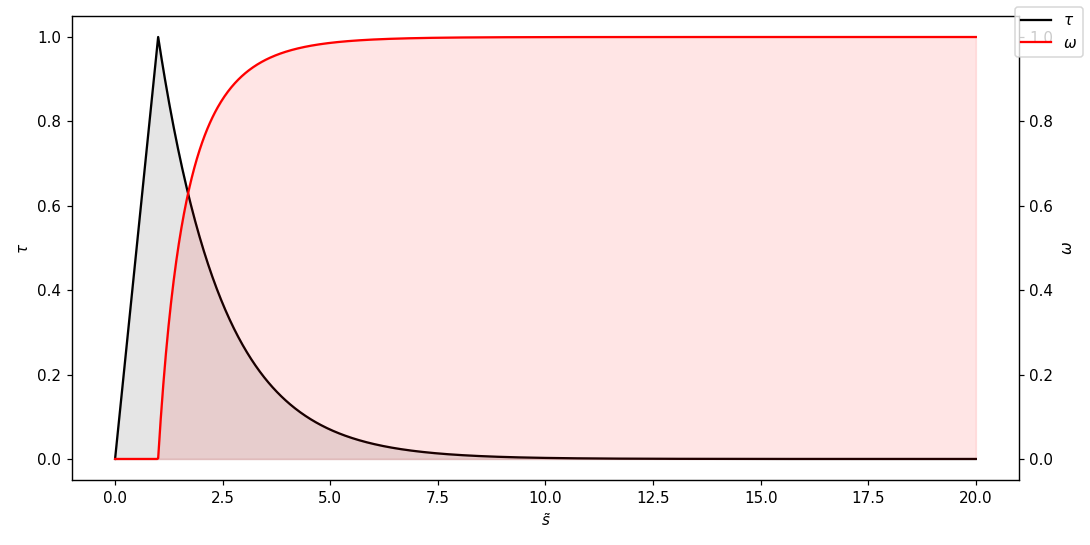

<string>:2: RuntimeWarning: divide by zero encountered in true_divide


In [32]:
get_g3 = sp.lambdify((s_equiv, E_b, s_0, G_f, '**kw'), g3_, 'numpy')
get_tau3 = sp.lambdify((s, s_equiv, E_b, s_0, G_f, '**kw'), tau3_, 'numpy')
_G_f = 2
s_arr=np.linspace(0,20,1000)
plot_damage(s_arr,
            get_g3(s_arr, E_b=1, s_0=1, G_f=_G_f), 
            get_tau3(s_arr, s_arr, E_b=1, s_0=1, G_f=_G_f));
# check the meaning of the G_f as an injected integral value
np.trapz(get_tau3(s_arr, s_arr, E_b=1, s_0=1, G_f=_G_f, L_s=1),s_arr)

# Summary and classification of damage evolution functions

| Symbol | Material parameters |
| :-: | :-: | 
| $g_1(\tilde{s})$ | $s_\mathrm{f}$ | 
| $g_2(\tilde{s})$ | $\alpha, s_\mathrm{u}$| 
| $g_3(\tilde{s})$ | $G_\mathrm{f}$ | 
| $g_4(\tilde{s})$ | data points
 

# Sheet interface - damage in 2D
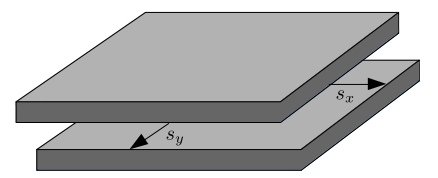

> <font color="brown"> **Is the material damaged equally in both in $x$ and in $y$ direction if we load it in $x$ direction?**
</font>

> If yes, we can use **isotropic damage model**
   


**What is the meaning of equivalent slip**

Distance from the origin $s_x, s_y = [0,0]$
\begin{align}
\tilde{s} =  \sqrt{ s^2_x(\theta) + s_y^2(\theta) }
\end{align}

In [15]:
s_x, s_y = sp.symbols('s_x, s_y')
s_equiv_ = sp.sqrt( s_x**2 + s_y**2 ) 
get_s_equiv = sp.lambdify( (s_x, s_y), s_equiv_, 'numpy' )

<IPython.core.display.Javascript object>


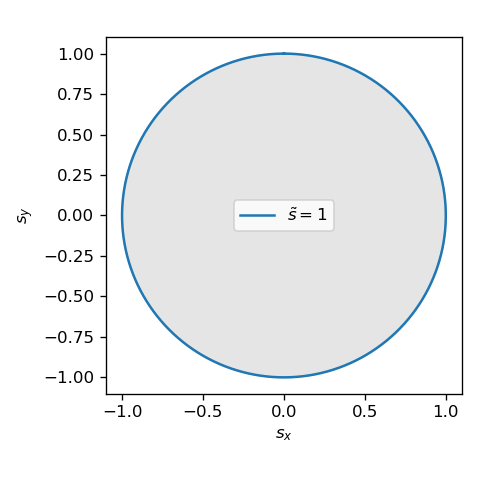

In [16]:
phi = np.linspace(0, 2*np.pi, 500)
sx, sy = np.sin(phi), np.cos(phi)
_, ax = plt.subplots(1,1, figsize=(4,4), tight_layout=True)
ax.plot(sx,sy,label=r'$\tilde{s} = 1$')
ax.fill(sx,sy, color='gray', alpha=0.2)
ax.set_xlabel(r'$s_x$'); ax.set_ylabel(r'$s_y$');
ax.set_aspect('equal'); ax.legend();

**2D elastic domain represented as a circle in $s_x$ and $s_y$ plane**
\begin{align}
f := \tilde{s} - s_0 \le 0
\end{align}

This condition is also referred to as **damage initiation criterion** or loading function in the literature
 * it plays the role of threshold function similarly to plastic models, **<font color="red">BUT</font>**
 * it is defined in strain, not in stress variables (slip variables for bond)

**How to treat unloading and reloading?**

... using maximum equivalent slip attained in the history:
\begin{align}
\kappa(t) = \max_{\theta < t} \tilde{s}(\theta) = \max_{\theta < t} \sqrt{ s^2_x(\theta) + s_y^2(\theta) }
\end{align}

Isotropic damage model uses a single damage variable for both slip directions:
\begin{align}
\tau_x &= (1 - \omega(\kappa)) \, E_b \, s_x \\
\tau_y &= (1 - \omega(\kappa)) \, E_b \, s_y
\end{align}

> **<font color="brown"> Damage increment caused in direction $x$ directly affects the behavior in direction $y$**
             </font>

Let us inspect the damage evolution for 2D loading histories in the space $\left[s_x, s_y, \sqrt{\tau_x^2 + \tau_y^2}\right]$

In [17]:
def get_tau_s(s_x_n1, s_y_n1, Eps_n, get_g, **kw):
    '''Get the stress for the slip in x, y dirctions given the state kappa_n'''
    _, _, kappa_n = Eps_n
    s_equiv = get_s_equiv(s_x_n1, s_y_n1)
    # adapt the shape of the state array 
    kappa_n_ = np.broadcast_to(kappa_n, s_equiv.shape)
    kappa_n1 = np.max(np.array([kappa_n_, s_equiv], dtype=np.float_),axis=0)
    E_b = kw['E_b']
    omega_n1 = 1 - get_g(kappa_n1, **kw)
    tau_x_n1 = (1 - omega_n1) * E_b * s_x_n1
    tau_y_n1 = (1 - omega_n1) * E_b * s_y_n1
    return (
        np.array([s_x_n1, s_y_n1, kappa_n1]),
        np.array([tau_x_n1, tau_y_n1, omega_n1])
    )

In [18]:
def plot_tau_s(ax, Eps_n, s_max, n_s, get_g, **kw):
    n_s_i = complex(0,n_s)
    s_x_n1, s_y_n1 = np.mgrid[-s_max:s_max:n_s_i, -s_max:s_max:n_s_i]
    Eps_n1, Sig_n1 = get_tau_s(s_x_n1, s_y_n1, Eps_n, get_g, **kw)
    s_x_n1, s_y_n1, _ = Eps_n1
    tau_x_n1, tau_y_n1, _ = Sig_n1
    tau_n1 = np.sqrt(tau_x_n1**2 + tau_y_n1**2)
    ax.plot_surface(s_x_n1, s_y_n1, tau_n1, alpha=0.2)
    phi=np.linspace(0,2*np.pi,100)
    _, _, kappa_n = Eps_n
    s_0 = kw['s_0']
    E_b = kw['E_b']
    r = max(s_0, kappa_n)
    omega_n = 1-get_g(r,**kw)
    f_t = (1-omega_n)*E_b*r
    s0_x, s0_y = r*np.sin(phi), r*np.cos(phi)
    ax.plot(s0_x, s0_y, 0, color='gray')
    ax.plot(s0_x, s0_y, f_t, color='gray')
    ax.set_xlabel(r'$s_x$ [mm]');ax.set_ylabel(r'$s_y$ [mm]');
    ax.set_zlabel(r'$\| \tau \| = \sqrt{\tau_x^2 + \tau_y^2}$ [MPa]');

<IPython.core.display.Javascript object>


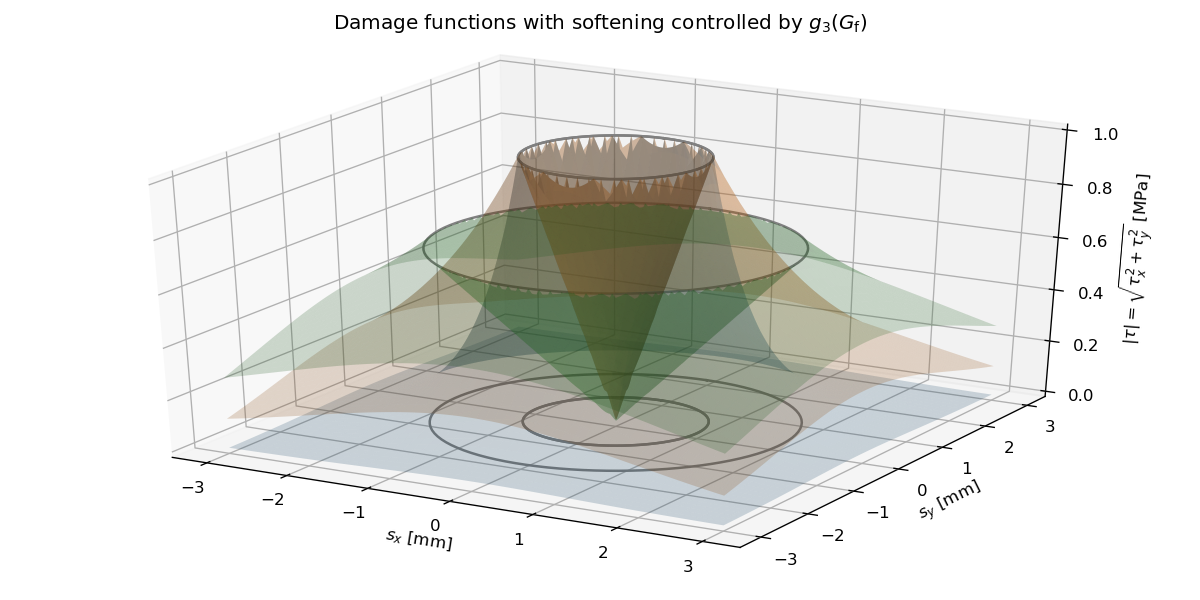

In [34]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
fig.suptitle(r'Damage functions with softening controlled by $g_3( G_\mathrm{f} )$')
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_tau_s(ax, [0,0,1], 3, 500, get_g3,E_b=1,s_0=1,G_f=1)
plot_tau_s(ax, [0,0,1], 3, 500, get_g3,E_b=1,s_0=1,G_f=2)
plot_tau_s(ax, [0,0,2], 3, 500, get_g3,E_b=1,s_0=1,G_f=3) 

<IPython.core.display.Javascript object>


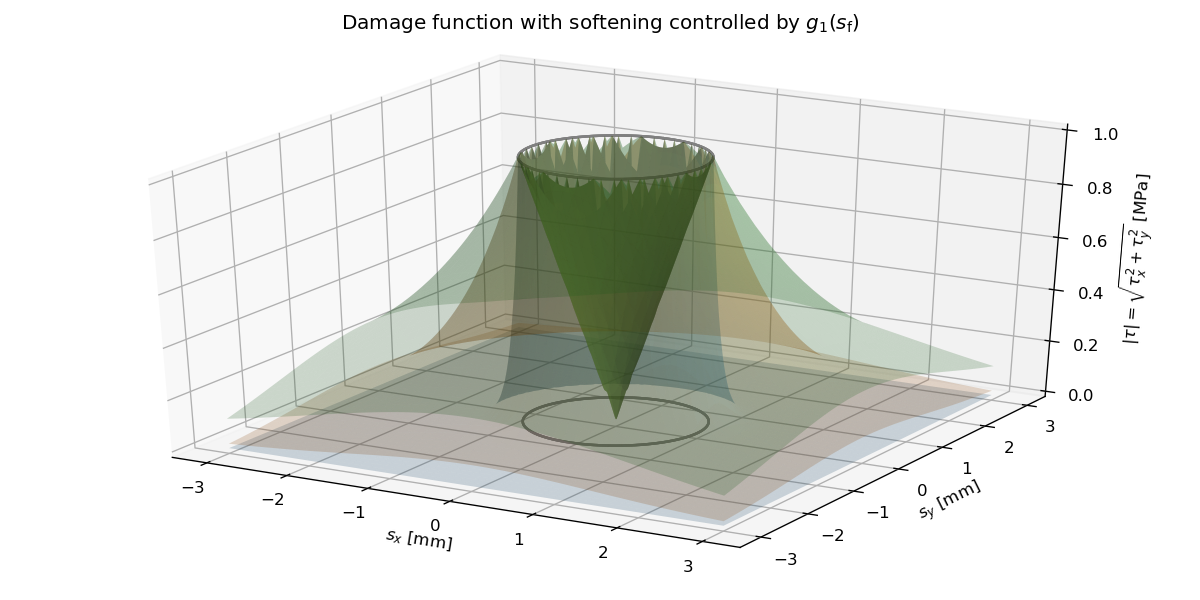

In [20]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
fig.suptitle(r'Damage function with softening controlled by $g_1(s_\mathrm{f})$')
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_tau_s(ax, [0,0,0], 3, 500, get_g1,E_b=1,s_0=1,s_f=1.1)
plot_tau_s(ax, [0,0,0], 3, 500, get_g1,E_b=1,s_0=1,s_f=1.8)
plot_tau_s(ax, [0,0,0], 3, 500, get_g1,E_b=1,s_0=1,s_f=2.5) 

# Test the 2D damage represented by the loss-of-integrity function $g_3(G_\mathrm{f})$
\begin{align}
g(\tilde{s}) = \displaystyle{\frac{s_0}{\tilde{s}}}
\exp\left(\frac{2 E_\mathrm{b} s_0 ( \tilde{s} - s_0) }
{E_\mathrm{b} s^2_0 - 2 G_\mathrm{f}} 
 \right)
\end{align}

<IPython.core.display.Javascript object>


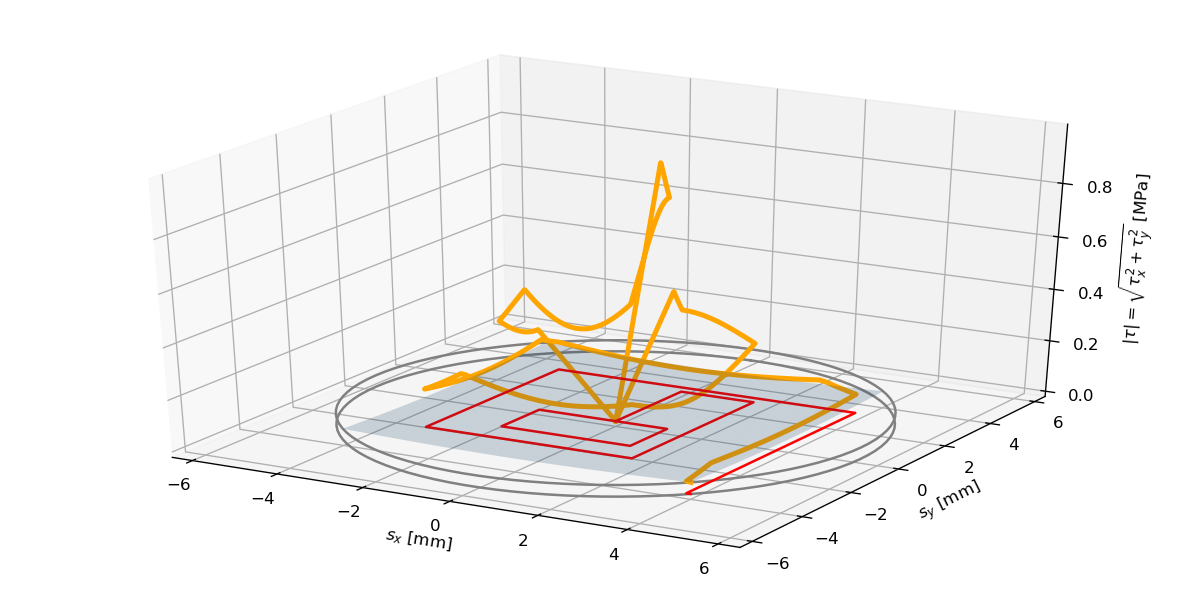

In [21]:
def init():
    global Eps_record, Sig_record
    global t_arr, s_x_t, s_y_t, s_x_0, s_y_0, t0, Eps_n1
    s_x_0, s_y_0 = 0, 0
    t0 = 0
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = []
    s_x_t, s_y_t = [], []
    Eps_n1 = np.zeros((3,), dtype=np.float_)

def get_response_i(s_x_1, s_y_1, n_steps = 60, **kw):
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, s_x_0, s_y_0, t0, Eps_n1
    t1 = t0+n_steps+1
    ti_arr = np.linspace(t0, t1, n_steps+1 )
    si_x_t = np.linspace(s_x_0,s_x_1,n_steps+1)
    si_y_t = np.linspace(s_y_0,s_y_1,n_steps+1)
    for s_x_n1, s_y_n1 in zip(si_x_t, si_y_t):
        Eps_n1, Sig_n1 = get_tau_s(s_x_n1, s_y_n1, Eps_n1, get_g3, **kw)
        Sig_record.append(Sig_n1)
        Eps_record.append(Eps_n1)
    t_arr = np.hstack([t_arr, ti_arr])
    s_x_t = np.hstack([s_x_t, si_x_t])
    s_y_t = np.hstack([s_y_t, si_y_t])
    t0 = t1
    s_x_0, s_y_0 = s_x_1, s_y_1
    return

def plot_Sig_Eps(ax1, s_x_t, s_y_t, Sig_arr, Eps_arr):
    tau_x, tau_y, kappa = Sig_arr.T
    tau = np.sqrt( tau_x**2 + tau_y**2 )
    ax1.plot3D(s_x_t, s_y_t, tau, color='orange', lw=3)

import ipywidgets as ipw
fig = plt.figure(figsize=(10,5), tight_layout=True)
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
def update(s_x_1, s_y_1):
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, s_x_0, s_y_0, t0, Eps_n
    global kw
    get_response_i(s_x_1, s_y_1, n_steps=50, **kw)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    ax1.clear()
    plot_tau_s(ax1, Eps_arr[-1,...],s_max,500,get_g3,**kw)
    plot_Sig_Eps(ax1, s_x_t, s_y_t, Sig_arr, Eps_arr)
    ax1.plot(s_x_t, s_y_t, 0, color='red')
    
s_max=4
n_s=500
s_x_1_slider = ipw.FloatSlider(description='s_x_1',
                               value=0,min=-s_max, max=+s_max, step=0.1,
                                         continuous_update=False)
s_y_1_slider = ipw.FloatSlider(description='s_y_1',value=0,min=-s_max, max=+s_max, step=0.1,
                                         continuous_update=False)

def reset(**material_params):
    global kw
    kw = material_params
    init()
    ax1.clear()
    s_x_1_slider.value = 0
    s_y_1_slider.value = 0
    plot_tau_s(ax1,[0,0,0],s_max,500,get_g3,**kw)

n_steps = 20
kw_sliders = {
    name : ipw.FloatSlider(description=name, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, val, minval, maxval in [('E_b', 1, 0.5, 100),
                                      ('s_0', 1, 0.00001, 2),
                                      ('G_f', 1, 0.0001, 10),
                                      ('L_s', 1, 0.0001, 10),]
}

kw = {key: s.value for key, s in kw_sliders.items()}

slip_sliders = {'s_x_1': s_x_1_slider, 's_y_1': s_y_1_slider}

def slider_layout(out1, out2):
    layout = ipw.Layout(grid_template_columns='1fr 1fr')
    slider_list = tuple(kw_sliders.values())
    grid = ipw.GridBox(slider_list, layout=layout)
    slip_slider_list = tuple(slip_sliders.values())
    hbox = ipw.HBox(slip_slider_list)
    box = ipw.VBox([hbox, grid, out1, out2])
    display(box)
    
init()
out1 = ipw.interactive_output(update, slip_sliders)
out2 = ipw.interactive_output(reset, kw_sliders);
slider_layout(out1, out2)

# Summary
 * Independent definition of **damage initiation** and **damage evolution** criteria
 * Independent refinements of both possible
 * **Isotropic damage** - affects all loading directions equally
 * **Anisotropic damage** - explicitly distinguishing between $s_x$ and $s_y$
 * At any state in history, radial unloading returns back to origin with zero stress

# Open questions

 * How is the damage model embedded in a FE simulation
     * As a material subroutine returning the stress and stiffness for a given slip/strain and $\kappa_n$
 * What is the instantaneous stiffness at control time $t$? needed in FE simulation
     * Secant stiffness is available directly as $\psi E_b$
     * Consistent algorithmic stiffness can be calculated as $\left. \frac{\partial \tau}{\partial s} \right|_t$
 * Can the damage model represent cracking?
     * Yes but we need to talk about energy first


# Links to manuals of non-linear FE tools

This brief introduction of damage modeling is meant as an entry point to reading more thorough documentation, e.g. the parts of software manuals describing damage.

 - [ABAQUS Manual: available damage functions](https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.5/books/usb/default.htm?startat=pt04ch11s06abm39.html)
 - [ATENA Manual: Stress-strain relations for concrete (Pages 18-21)](https://www.cervenka.cz/assets/files/atena-pdf/ATENA_Theory.pdf) 